# Amazon Titan Image Generator v2 Workshop: Creating a Visual Ad for Octank Dog Food


## Introduction

Welcome to the Amazon Titan Image Generator v2 Workshop! In this hands-on session, we'll explore the powerful capabilities of Amazon Titan Generator v2 to create a compelling visual ad for Octank, a premium dog food company.


### Use Case

Octank is launching a new dog food line and wants to create a visual ad. They have specific requirements:

1. Use an image of the owner's American Eskimo dog as inspiration for the product packaging design.
2. Create a special promotional package design using their brand color palette (yellow, blue, and gray).
3. Create a professional-looking ad with the product in filming studio background.


### Workshop Objectives

By the end of this workshop, you will:

1. Understand the key features of Amazon Titan Image Generator v2

2. Learn how to use these features for a real-world marketing scenario

3. Gain hands-on experience with the Amazon Bedrock API for image generation tasks

### Features We'll Use

During the workshop, we'll leverage the following features of Amazon Titan Image Generator v2:

1. Image Conditioning: To create an initial product package design inspired by the reference image
2. Color Conditioning: To generate a special promotional package design using Octank's brand color palette
3. Outpainting: To create a professional-looking ad with product in filming studio background
4. Background Removal: To isolate the product image for use in various marketing materials




## Setup

⚠️ ⚠️ ⚠️ Before running this notebook, make sure you've completed the setup in the ['Getting Started' section of the root README](https://github.com/aws-samples/amazon-bedrock-workshop/blob/main/README.md#Getting-started). ⚠️ ⚠️ ⚠️

Make sure you have enabled `amazon.titan-image-generator-v2:0` model access.


In [1]:
# Built-in libraries
import base64
import io
import json
import os
import sys

# External dependencies
import boto3
import botocore
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# Set up Bedrock client
boto3_bedrock = boto3.client('bedrock-runtime')

In [2]:
# Define plot function
def plot_images(base_images, prompt=None, seed=None, ref_image_path=None, color_codes=None, original_title=None, processed_title=None):
    if ref_image_path and color_codes:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        num_subplots = 3
    elif ref_image_path or color_codes:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        num_subplots = 2
    else:
        fig, axes = plt.subplots(1, 1, figsize=(6, 5))
        num_subplots = 1
    
    axes = np.array(axes).ravel() 
    
    current_subplot = 0
    
    if color_codes:
        num_colors = len(color_codes)
        color_width = 0.8 / num_colors
        for i, color_code in enumerate(color_codes):
            x = i * color_width
            rect = plt.Rectangle((x, 0), color_width, 1, facecolor=f'{color_code}', edgecolor='white')
            axes[current_subplot].add_patch(rect)
        axes[current_subplot].set_xlim(0, 0.8)
        axes[current_subplot].set_ylim(0, 1)
        axes[current_subplot].set_title('Color Codes')
        axes[current_subplot].axis('off')
        current_subplot += 1
    
    if ref_image_path:
        reference_image = Image.open(ref_image_path)
        max_size = (512, 512)
        reference_image.thumbnail(max_size)
        axes[current_subplot].imshow(np.array(reference_image))
        axes[current_subplot].set_title(original_title or 'Reference Image')
        axes[current_subplot].axis('off')
        current_subplot += 1
    
    axes[current_subplot].imshow(np.array(base_images[0]))
    if processed_title:
        axes[current_subplot].set_title(processed_title)
    elif ref_image_path and seed is not None:
        axes[current_subplot].set_title(f'Image Generated Based on Reference\nSeed: {seed}')
    elif seed is not None:
        axes[current_subplot].set_title(f'Image Generated\nSeed: {seed}')
    else:
        axes[current_subplot].set_title('Processed Image')
    axes[current_subplot].axis('off')
    
    if prompt:
        print(f"Prompt: {prompt}\n")
    
    plt.tight_layout()
    plt.show()

In [3]:
# Define function to save the output
def save_image(base64_image, output_file):
    image_bytes = base64.b64decode(base64_image)
    image = Image.open(io.BytesIO(image_bytes))
    image.save(output_file)

### Step 1: Image Conditioning

##### Background

Amazon Titan Image Generator v2 offers two image conditioning modes:

- Canny Edge: Extract prominent edges from the reference image to guide the generation process.

- Segmentation: Define specific regions/objects within the reference image for the model to generate content aligned with those areas.

Main parameters can be specified include:

* `text` - (Required) A text prompt to generate the image, must be <= 512 characters
* `negativeText` - (Optional) A text prompt to define what not to include in the image, must be <= 512 characters
* `conditionImage` - (Optional, V2 only) A base64-encoded string representing an input image to guide the layout and composition of the generated image
* `controlMode` - (Optional, V2 only) Specifies the type of conditioning mode: `CANNY_EDGE` (default) or `SEGMENTATION`
* `controlStrength` - (Optional, V2 only) Determines how similar the generated image should be to the condition image, range 0 to 1.0 (default: 0.7)
* `numberOfImages` - The number of images to generate
* `height` - The height of the generated image(s)
* `width` - The width of the generated image(s)
* `cfgScale` - Determines how closely the image adheres to the prompt
* `seed` - An integer used to initialize the image generation process

Note: The longer side of the image resolution must be <= 1,408 pixels. If `controlMode` or `controlStrength` are provided, `conditionImage` must also be provided.

##### Now, let's start by using the reference image of the owner's American Eskimo to create a product package design

In [6]:
# Define the prompt and reference image
prompt = "A white packet of premium dog food with an American Eskimo dog on it, professional product photography. Dog food is named Octank"

#prompt = "A white packet of premium dog food with an American Eskimo dog on it, outdoor background, professional product photography. Dog food is named Octank"

reference_image_path = "generated_dog.png"
seed = 42

# Specify path to store the output
output_save_path = "after_image_conditioning.png" 

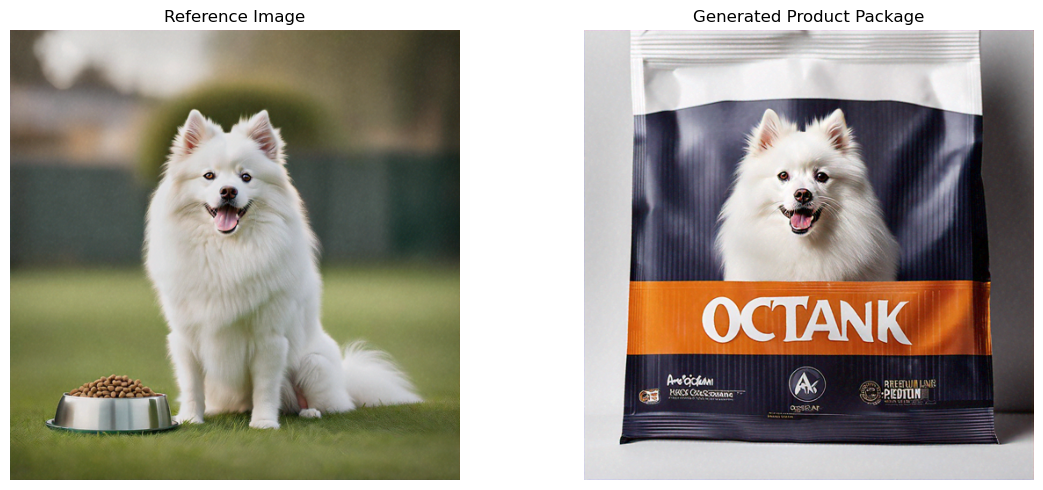

In [7]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

# Generate image conditioned on reference image
body = json.dumps({
    "taskType": "TEXT_IMAGE",
    "textToImageParams": {
        "text": prompt,
        "conditionImage": reference_image_base64,
        "controlMode": "CANNY_EDGE",
        "controlStrength": 0.7,
    },
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "seed": seed,
    }
})

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# save output
save_image(response_body.get("images")[0], output_save_path)

# Plot output
plot_images(response_images, ref_image_path=reference_image_path, 
            original_title="Reference Image", processed_title="Generated Product Package")

Result is looking promising! Before we head into next step, let's complete some **bonus tasks** to explore more with image conditioning feature.

##### - Canny Edge Mode:

We will use our Eskimo dog image to generate a cartoon style dog food packet with canny edge mode, which extracts prominent edges from the reference image to guide the generation process.

In [13]:
# Define the prompt, reference image
prompt = "a cartoon dog food packet with a white american eskimo on the packet cover."
reference_image_path = "after_image_conditioning.png"
seed = 42 # Can be any random number between 0 to 214783647
output_save_path = "after_image_cartooning.png" 

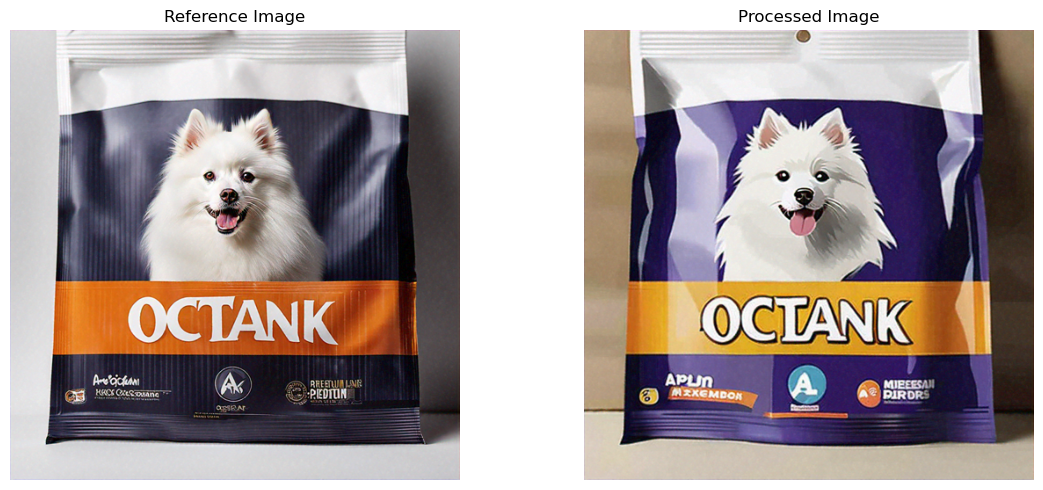

In [14]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,  # Required
            "conditionImage": reference_image_base64, # Optional
            "controlMode": "CANNY_EDGE", # Optional: CANNY_EDGE | SEGMENTATION
            "controlStrength": 0.7,  # Range: 0.2 to 1.0,
        },
        "imageGenerationConfig": {
                "numberOfImages": 1,
                "seed": seed,
            }
        
    }
)

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

save_image(response_body.get("images")[0], output_save_path)

# plot output
plot_images(response_images, ref_image_path = reference_image_path)

##### - Segmentation Mode:

We will then generate a dog food bowl placed near cartoon dog food packet using Segmentation mode, which defines specific regions/objects within the reference image for the model to generate content aligned with those areas.

In [16]:
# Define the prompt, reference image 
prompt = "Metal dog food bowl placed near the OCTANK dog food packet with a cartoon white american eskimo on the packet, placed on green grass outdoor"
reference_image_path = "after_image_cartooning.png" 
seed = 5 # Can be any random number between 0 to 214783647
output_save_path = "after_image_placing.png" 

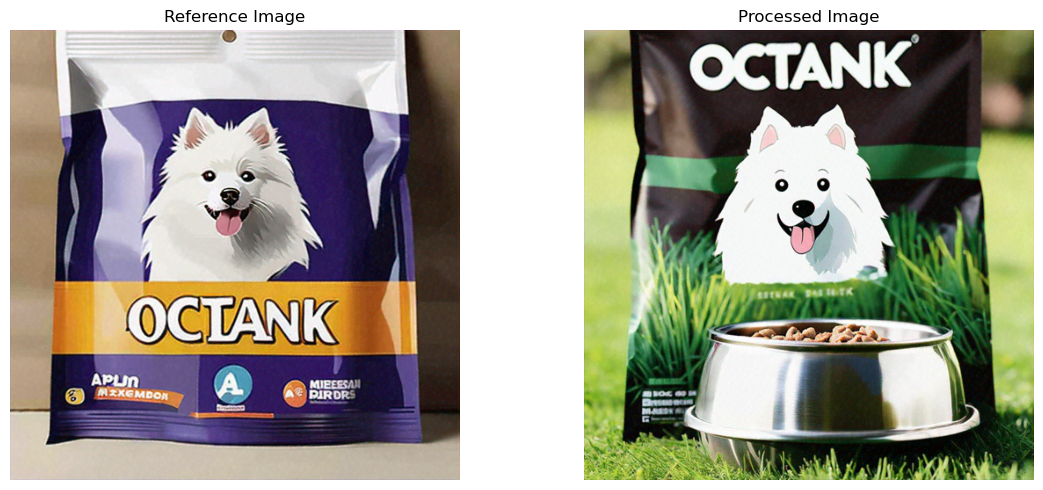

In [18]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,  # Required
            "conditionImage": reference_image_base64, # Optional
            "controlMode": "SEGMENTATION", # Optional: CANNY_EDGE | SEGMENTATION
            "controlStrength": 0.6,  # Range: 0.2 to 1.0,
        },
        "imageGenerationConfig": {
                "numberOfImages": 1,
                "seed": seed,
            }
        
    }
)

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]
save_image(response_body.get("images")[0], output_save_path)

# plot output
plot_images(response_images, ref_image_path = reference_image_path)

### Step 2: Color Conditioning

##### Background

Amazon Titan Image Generator v2's color conditioning feature allows users to generate images that follow a specified color palette. This can be done with or without a reference image. Here's Octank's color palette:

![image](images/octank_color_palette.JPG)

Here's a summary of the parameters for color conditioning:

* `text` - (Required) A text prompt to generate the image, must be <= 512 characters
* `colors` - (Required) A list of 1 to 10 hex color codes to specify colors in the generated image
* `negativeText` - (Optional) A text prompt to define what not to include in the image, must be <= 512 characters
* `referenceImage` - (Optional) A base64-encoded string representing an input image to guide the color palette of the generated image
* `numberOfImages` - The number of images to generate
* `height` - The height of the generated image(s)
* `width` - The width of the generated image(s)
* `cfgScale` - Determines how closely the image adheres to the prompt
* `seed` - An integer used to initialize the image generation process

Users can (optional) upload a single reference image that is similar to their desired output. The model will then generate images that follow the style and fashion of this reference image while incorporating the specified color palette.

##### Now, let's create a special promotional package design using Octank's brand color palette.

In [19]:
# Define the prompt, reference image, color code and path to store the generated images
reference_image_path = "after_image_cartooning.png" 
prompt = "a cartoon white american eskimo on the cover of OCTANK dog food packet"
hex_color_code = ['#ffe599', '#3d85c6', '#eeeeee']
seed = 42 # Can be any random number between 0 to 214783647

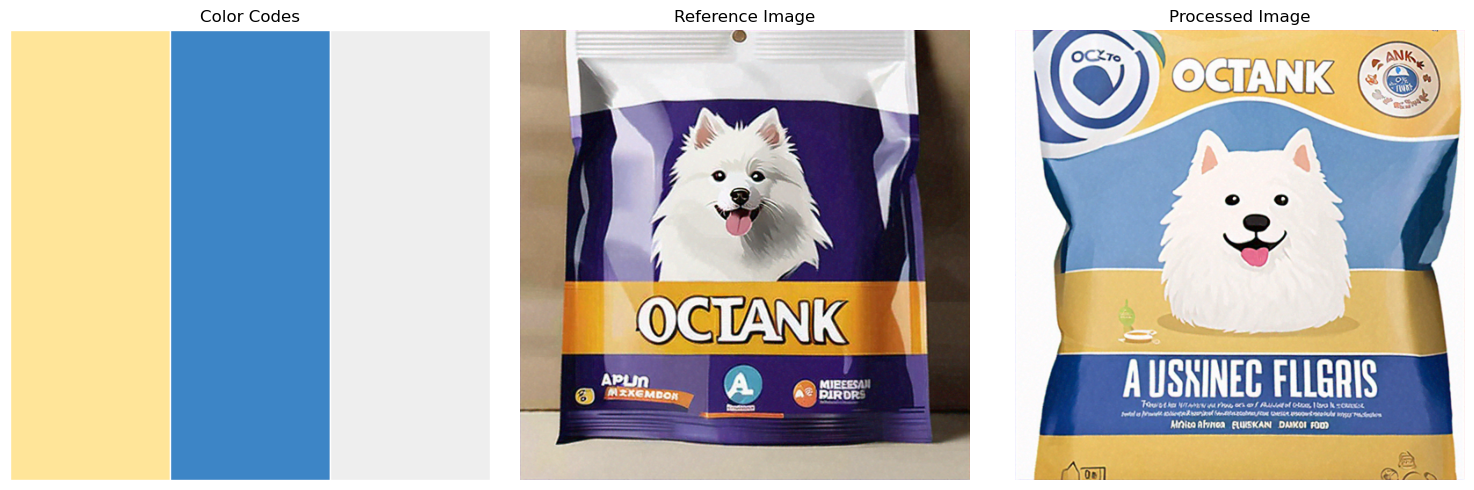

In [21]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
    
# Generate image condition on color palette
body = json.dumps({
    "taskType": "COLOR_GUIDED_GENERATION",
    "colorGuidedGenerationParams": {
        "text": prompt,
        "colors": hex_color_code,
        "referenceImage": reference_image_base64,
    },
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "seed": seed,
    }
})

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]


# plot output
plot_images(response_images, ref_image_path = reference_image_path, color_codes = hex_color_code)

### Step 3: Outpainting

Now, Octank wants to create a professional-looking ad with this new product with filming studio background. To do this kind of background replacement, we will use the outpainting feature offered by Titan Image Generator models. 

We will first expand the image size to provide more room, then generating the new image using outpainting feature.

In [22]:
# Define the prompt and reference image
prompt = "filming studio background, the dog food packet is on a stand"
reference_image_path = "after_image_cartooning.png" 
mask_prompt = "Dog food packet"
seed = 1

# Expansion setting
target_width = 1024
target_height = 1024
horizontal_position_percent=0.3
vertical_position_percent=0.5
expand_image_path = "expanded_image.png"

In [ ]:
# Load reference image
original_image = Image.open(reference_image_path)
original_width, original_height = original_image.size

# Calculate the position of the original image on the expanded canvas.
position = (
    int((target_width - original_width) * horizontal_position_percent),
    int((target_height - original_height) * vertical_position_percent),
)

# Create an input image which contains the original image with an expanded
# canvas.
input_image = Image.new("RGB", (target_width, target_height), (235, 235, 235))
input_image.paste(original_image, position)
input_image.save(expand_image_path)
    
# Encode the reference image
with open(expand_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

    
# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": prompt,  # Required
            "image": reference_image_base64,  # Required
            "maskPrompt": mask_prompt,  # One of "maskImage" or "maskPrompt" is required
            "outPaintingMode": "PRECISE",  # One of "PRECISE" or "DEFAULT"
        },
        "imageGenerationConfig": {
                "numberOfImages": 1,
                "seed": seed,
            }
        
    }
)

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# plot output
plot_images(response_images, ref_image_path = reference_image_path)

### Bonus task: Background Removal

Octank has professional photos of their existing gourmet dog food. They want to use these images across various marketing materials with different background. In our last use case, we will use Background Removal feature from Titan Image Generator v2 to help Ocktank isolate its product image from their original backgrond.

To use this feature, you just need to provide the image the model needs to work with. 

In [25]:
# Define image needs to be processed and path to store the generated images
reference_image_path = "after_image_cartooning.png" 

In [ ]:
# Read image from file and encode it as base64 string.
with open(reference_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode('utf8')

body = json.dumps({
    "taskType": "BACKGROUND_REMOVAL",
    "backgroundRemovalParams": {
        "image": input_image,
    }
})

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.titan-image-generator-v2:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# plot output
plot_images(response_images, ref_image_path= reference_image_path, original_title='Original Image', processed_title='Processed Image without Background')

# Summary

In this workshop, we explored the powerful features of Amazon Titan Image Generator v2 through the lens of Octank, a premium dog food company. We covered:

- Image Conditioning
- Color Conditioning
- Outpainting
- Background Removal

These tools enable Octank to efficiently create diverse, high-quality visuals for their marketing campaigns, maintaining brand consistency while adapting to various styles.

You can now leverage this GenAI-powered image generation to enhance your own creative workflows!